In [1]:
!pip install -qU "semantic-router[fastembed]" langchain langchain_community langchain_core openai pymilvus bs4 "grpcio<=1.63.0,>=1.49.1" semantic-chunkers==0.0.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
semantic-chunkers 0.0.3 requires semantic-router<0.0.40,>=0.0.39, but you have semantic-router 0.0.52 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import requests
from bs4 import BeautifulSoup
import os
import time
from langchain_core.documents import Document
from openai import OpenAI
from urllib.parse import urlparse, urljoin
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection

In [2]:
ZILLIZ_CLOUD_URI = ""  # example: "https://in01-17f69c292d4a5sa.aws-us-west-2.vectordb.zillizcloud.com:19536"
ZILLIZ_CLOUD_API_KEY = ""
COLLECTION_NAME="trial"
DIMENSION=1029

## Prepare Data: Stratergy to Extract the Data from the root-URL

Technique Applied:

In [4]:
def get_main_links(url):
  response = requests.get(url)
  soup = BeautifulSoup(response.content, 'html.parser')
  main_links = []

  # Extracting links with "index.html" considering nesting
  for a in soup.find_all('a', href=True):
    href = a['href']
    if href and href.endswith("index.html"):  # Check for ending with "index.html"
      full_url = urljoin(url, href)
      # Avoid duplicate links and links pointing to external domains
      if full_url not in main_links and full_url.startswith(url):
        main_links.append(full_url)

  return main_links

# Function to extract subsection links from a main link
def get_subsection_links(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    subsection_links = []
    for link in soup.find_all('a', href=True):
        href = link['href']
        full_url = urljoin(url, href)
        if '#' in full_url and full_url not in subsection_links:
            subsection_links.append(full_url)
    return subsection_links

# Function to extract the main content by section ID and its subsections
def extract_section_content(cached_soup, section_id):
  section_content = []
  soup = cached_soup  # Use the cached soup object

  main_section = soup.find('section', {'id': section_id})

  if main_section:
    for element in main_section.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p', 'li', 'pre']):
            if element.name in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
                section_content.append('\n' + element.get_text().upper() + '\n')
            elif element.name == 'p':
                section_content.append(element.get_text() + '\n\n')
            elif element.name == 'li':
                section_content.append('* ' + element.get_text() + '\n')
            elif element.name == 'pre':  # for code blocks
                section_content.append('\n' + element.get_text() + '\n')

  return '\n'.join(section_content)

def extract_main_section_ids(url):
  response = requests.get(url)
  soup = BeautifulSoup(response.content, 'html.parser')

  # Find all sections with an ID attribute
  sections_with_id = soup.find_all('section', {'id': True})

  # This list will store top-level section IDs (no nested sections)
  main_section_ids = []

  # Iterate through sections with ID
  for section in sections_with_id:
    # Check if the current section has a parent section with an ID
    if not section.parent or not section.parent.has_attr('id'):
      # If no parent ID, it's likely a top-level section
      main_section_ids.append(section['id'])

  return main_section_ids, soup

def create_document(content, main_link, section_id):
  doc_data = Document(page_content=content, metadata = {"source_link":main_link, "section_id":section_id})
  return doc_data

# Main function to orchestrate the extraction and saving process
def main():
    base_url = 'https://docs.nvidia.com/cuda/'
    output_folder = 'nvidia_docs_content'
    main_document_list = []

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Step 1: Extract main links
    main_links = get_main_links(base_url)
    
    # Step 2: Extract subsection links and save content
    for main_link in main_links:
        # Extract main section IDs dynamically
        main_section_ids, soup = extract_main_section_ids(main_link)
        # Extract and save content grouped by main sections
        for section_id in main_section_ids:
            if section_id!="notices":
              content = extract_section_content(soup, section_id)
              if content:
                  sub_doc = create_document(content, main_link, section_id)
                  main_document_list.append(sub_doc)

    return main_document_list

if __name__ == '__main__':
    lst = main()

In [229]:
main_document_list

[Document(metadata={'source_link': 'https://docs.nvidia.com/cuda/cuda-quick-start-guide/index.html', 'section_id': 'introduction'}, page_content='\n1. INTRODUCTION\uf0c1\n\nThis guide covers the basic instructions needed to install CUDA and verify that a CUDA application can run on each supported platform.\n\n\nThese instructions are intended to be used on a clean installation of a supported platform. For questions which are not answered in this document, please refer to the Windows Installation Guide and Linux Installation Guide.\n\n\nThe CUDA installation packages can be found on the CUDA Downloads Page.\n\n'),
 Document(metadata={'source_link': 'https://docs.nvidia.com/cuda/cuda-quick-start-guide/index.html', 'section_id': 'windows'}, page_content='\n2. WINDOWS\uf0c1\n\nWhen installing CUDA on Windows, you can choose between the Network Installer and the Local Installer. The Network Installer allows you to download only the files you need. The Local Installer is a stand-alone instal

## Calculate Chunk Size Distibution

In [ ]:
from typing import Optional, List, Tuple
def calculate_total_and_count(docs: list, index: int = 0) -> Tuple[int, int]:
    if index >= len(docs):
        return (0, 0)
    current_chunk_size = len(docs[index].page_content)
    total_length, count = calculate_total_and_count(docs, index + 1)
    return (current_chunk_size + total_length, count + 1)

def get_average_chunk_size(docs: list) -> float:
    total_length, count = calculate_total_and_count(docs)
    if count == 0:
        return 0.0
    return total_length / count

In [ ]:
get_average_chunk_size(lst)

22552.35855263158

In [ ]:
import matplotlib.pyplot as plt
def get_chunk_sizes(docs: List) -> List[int]:
    return [len(doc.page_content) for doc in docs]

# Function to plot bar chart
def plot_chunk_sizes(docs: List[str]):
    chunk_sizes = get_chunk_sizes(docs)
    chunk_numbers = range(1, len(chunk_sizes) + 1)  # Chunk numbers start from 1

    plt.figure(figsize=(10, 6))
    plt.bar(chunk_numbers, chunk_sizes, color='skyblue')
    plt.xlabel('Chunk Number')
    plt.ylabel('Size of Chunk')
    plt.title('Chunk Sizes Bar Plot')
    plt.xticks(chunk_numbers)  # Ensure chunk numbers are shown as integers
    plt.show()

In [ ]:
plot_chunk_sizes(lst)

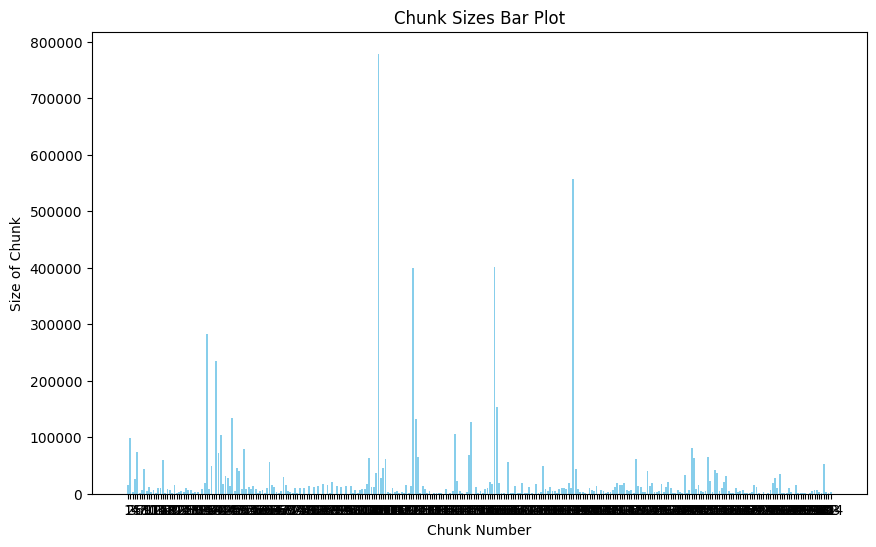

## Semantic Chunking

In [335]:
import re

text = main_document_list[2].page_content

import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', text)
print (f"{len(single_sentences_list)} senteneces were found")

456 senteneces were found


In [320]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]
sentences[:3]

[{'sentence': '\n3.', 'index': 0},
 {'sentence': 'LINUX\uf0c1\n\nCUDA on Linux can be installed using an RPM, Debian, Runfile, or Conda package, depending on the platform being installed on.',
  'index': 1},
 {'sentence': '3.1.', 'index': 2}]

In [321]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [278]:
sentences

[{'sentence': '\n1.',
  'index': 0,
  'combined_sentence': '\n1. INTRODUCTION\uf0c1\n\nThis guide covers the basic instructions needed to install CUDA and verify that a CUDA application can run on each supported platform.'},
 {'sentence': 'INTRODUCTION\uf0c1\n\nThis guide covers the basic instructions needed to install CUDA and verify that a CUDA application can run on each supported platform.',
  'index': 1,
  'combined_sentence': '\n1. INTRODUCTION\uf0c1\n\nThis guide covers the basic instructions needed to install CUDA and verify that a CUDA application can run on each supported platform. These instructions are intended to be used on a clean installation of a supported platform.'},
 {'sentence': 'These instructions are intended to be used on a clean installation of a supported platform.',
  'index': 2,
  'combined_sentence': 'INTRODUCTION\uf0c1\n\nThis guide covers the basic instructions needed to install CUDA and verify that a CUDA application can run on each supported platform. Th

In [290]:
from langchain.embeddings import OpenAIEmbeddings
oaiembeds = CustomEmbedClass(client=aiml_client)

In [322]:
from langchain_community.embeddings import OllamaEmbeddings
oaiembeds = OllamaEmbeddings(model="mxbai-embed-large")

In [323]:
embeddings = oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])

In [306]:
embeddings

[[-0.08766789734363556,
  0.12778589129447937,
  0.3949185907840729,
  -0.03185419738292694,
  -0.5162289142608643,
  -0.0368887335062027,
  0.32606568932533264,
  -0.40646788477897644,
  0.5515044331550598,
  1.1966731548309326,
  -0.4674786329269409,
  0.11003293097019196,
  0.26327216625213623,
  -0.3667459189891815,
  -0.10990633070468903,
  0.3728809654712677,
  -0.2927999198436737,
  -0.7920867800712585,
  -0.9292101263999939,
  0.21205557882785797,
  0.16174253821372986,
  0.012614617124199867,
  -1.008337378501892,
  -0.20208749175071716,
  0.06251251697540283,
  0.27365928888320923,
  0.3117217421531677,
  -0.05154573917388916,
  0.8284030556678772,
  0.14940142631530762,
  -0.7465742230415344,
  0.3653329908847809,
  -0.019925333559513092,
  -0.5228128433227539,
  -0.27858471870422363,
  -0.5432465076446533,
  0.578847348690033,
  -0.3383546471595764,
  -0.3443819582462311,
  -0.04632776230573654,
  0.05477412790060043,
  0.41504544019699097,
  1.0112961530685425,
  -0.272762

In [330]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [309]:
!pip install scikit-learn

  Using cached scikit_learn-1.5.1-cp310-cp310-win_amd64.whl.metadata (12 kB)
  Using cached scipy-1.14.0-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.1-cp310-cp310-win_amd64.whl (11.0 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.14.0-cp310-cp310-win_amd64.whl (44.8 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [325]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [326]:
distances, sentences = calculate_cosine_distances(sentences)

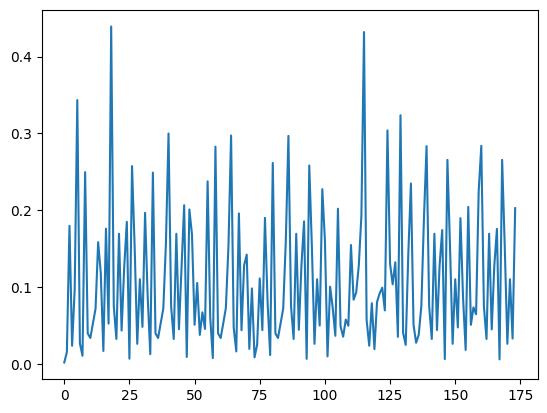

In [327]:
import matplotlib.pyplot as plt

plt.plot(distances);

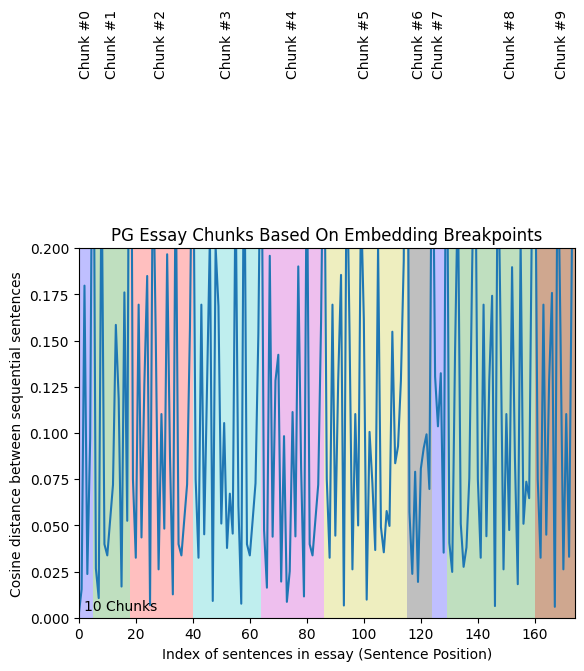

In [328]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

In [331]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

In [333]:
chunks

['\n3. LINUX\uf0c1\n\nCUDA on Linux can be installed using an RPM, Debian, Runfile, or Conda package, depending on the platform being installed on. 3.1. LINUX X86_64\uf0c1\n\nFor development on the x86_64 architecture. In some cases, x86_64 systems may act as host platforms targeting other architectures. See the Linux Installation Guide for more details.',
 '3.1.1. REDHAT / CENTOS\uf0c1\n\nWhen installing CUDA on Redhat or CentOS, you can choose between the Runfile Installer and the RPM Installer. The Runfile Installer is only available as a Local Installer. The RPM Installer is available as both a Local Installer and a Network Installer. The Network Installer allows you to download only the files you need. The Local Installer is a stand-alone installer with a large initial download. In the case of the RPM installers, the instructions for the Local and Network variants are the same. For more details, refer to the Linux Installation Guide. 3.1.1.1. RPM INSTALLER\uf0c1\n\nPerform the fol

## Conclusion: 

Semantic Chunking Performs Better, It Splits the chunks Accurately as per above, New Chunks splitted based upon the Clustering of sentences based upon similr Topics, As per above You can see, New Chunk Started with New Topic.

## Limitation: 
Limitation Noticed: We can't control the chunk Size how much it should limit or create the chunk, It affects the generalisation and Can only be useful for Embedding or Completion Models with Larger Seqence Lengths. Hence, For Smaller and More generic Way Used Rolling Window Techniue

## Rolling Window Semantic Chunking

In [17]:
from semantic_router.splitters import RollingWindowSplitter
from semantic_router.utils.logger import logger
from semantic_router.encoders import FastEmbedEncoder

encoder = FastEmbedEncoder(name="BAAI/bge-small-en-v1.5")

encoder.score_threshold = 0.3

splitter = RollingWindowSplitter(
    encoder=encoder,
    dynamic_threshold=False,
    min_split_tokens=100,
    max_split_tokens=500,
    window_size=3,
    plot_splits=True,  # set this to true to visualize chunking
    enable_statistics=True  # to print chunking stats
)

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 75709.46it/s]


In [36]:
splits = splitter([lst[0].page_content])
doc_metadata = lst[0].metadata

2024-07-15 11:34:37 INFO semantic_router.utils.logger Single document exceeds the maximum token limit of 500. Splitting to sentences before semantically splitting.
2024-07-15 11:34:42 WARNING semantic_router.utils.logger Plotting is disabled. Please `pip install semantic-router[processing]`.


Splitting Statistics:
  - Total Documents: 449
  - Total Splits: 9
  - Splits by Threshold: 0
  - Splits by Max Chunk Size: 8
  - Last Split: 1
  - Minimum Token Size of Split: 261
  - Maximum Token Size of Split: 500
  - Similarity Split Ratio: 0.00


## Conclusion: 
It Splits The chunks Based on the window Size and Splits Based upon the Maximum Chunk Size given. It Can be useful for Smaller Sequence Length models & More Iterative Approach i.e. By changing Hyperparameters like window Size, Score_Threshold, chunk sizes Performace is Adjustable. Hence For **Production Use Rolling Window Chunking Technique**

## Metadata Stratergy:

Stored Source_link, Section_id, Prechunk and Postchunk into the metadata. Prechunk and Postchunk are a part of Bigger Chunk and contains semantically important information relevant to Current Chunk.. Hence By Storing this information, At the Time of Response Generation This will be useful.

In [ ]:
from semantic_router.schema import DocumentSplit
from langchain_core.documents import Document
def build_metadata(doc_metadata:dict, splits: list[DocumentSplit]):
    source_link_meta = doc_metadata['source_link']
    section_id_meta = doc_metadata['section_id']
    final_doc = []
    for i, split in enumerate(splits):
        prechunk = [splits[i-2].content if i-2 >= 0 else "", splits[i-1].content if i-1 >= 0 else ""]
        postchunk = [splits[i+1].content if i+1 < len(splits) else "", splits[i+2].content if i+2 < len(splits) else ""]
        page_content = split.content 
        metadata = { 
            "prechunk": prechunk,
            "postchunk": postchunk,
            "source_link": source_link_meta,
            "section_id" : section_id_meta
        }
        doc_obj = Document(page_content=page_content, metadata=metadata)
        final_doc.append(doc_obj)

    return final_doc

In [ ]:
final_data = build_metadata(doc_metadata, splits)
final_data

[Document(metadata={'prechunk': ['', ''], 'postchunk': ['x86_64 Linux, Windows CUDA nvprune 12.5.82 x86_64, arm64-sbsa, aarch64-jetson Linux, Windows, WSL CUDA NVRTC 12.5.82 x86_64, arm64-sbsa, aarch64-jetson Linux, Windows, WSL NVTX 12.5.82 x86_64, arm64-sbsa, aarch64-jetson Linux, Windows, WSL CUDA NVVP 12.5.82 x86_64, Linux, Windows CUDA OpenCL 12.5.39 x86_64 Linux, Windows CUDA Profiler API 12.5.39 x86_64, arm64-sbsa, aarch64-jetson Linux, Windows, WSL CUDA Compute Sanitizer API 12.5.81 x86_64, arm64-sbsa, aarch64-jetson Linux, Windows, WSL CUDA cuBLAS 12.5.3.2 x86_64, arm64-sbsa, aarch64-jetson Linux, Windows, WSL cuDLA 12.5.82 aarch64-jetson Linux CUDA cuFFT 11.2.3.61 x86_64, arm64-sbsa, aarch64-jetson Linux, Windows, WSL CUDA cuFile 1.10.1.7 x86_64, arm64-sbsa, aarch64-jetson Linux CUDA cuRAND 10.3.6.82 x86_64, arm64-sbsa, aarch64-jetson Linux, Windows, WSL CUDA cuSOLVER 11.6.3.83 x86_64, arm64-sbsa, aarch64-jetson Linux, Windows, WSL CUDA cuSPARSE 12.5.1.3 x86_64, arm64-sbsa, a

In [ ]:
from pymilvus import connections, Collection, utility

In [ ]:
connections.connect(
    uri=ZILLIZ_CLOUD_URI,
    token=ZILLIZ_CLOUD_API_KEY
)

utility.get_server_version()
if utility.has_collection(COLLECTION_NAME):
    utility.drop_collection(COLLECTION_NAME)
else:
    print(f"New Collection -> {COLLECTION_NAME}")

NameError: name 'connections' is not defined

In [ ]:
for i, chunk in enumerate(chunks):
    build_chunks(chunks)

Chunk #0
3. LINUX

CUDA on Linux can be installed using an RPM, Debian, Runfile, or Conda package, depending on the platform being installed on. 3.1. LINUX X86_64

For development on the x86_64 architecture. In some cases, x86_64 systems may act as host platforms targeting other architectures. See the Linux Installation Guide for more details.
Chunk #1
3.1.1. REDHAT / CENTOS

When installing CUDA on Redhat or CentOS, you can choose between the Runfile Installer and the RPM Installer. The Runfile Installer is only available as a Local Installer. The RPM Installer is available as both a Local Installer and a Network Installer. The Network Installer allows you to download only the files you need. The Local Installer is a stand-alone installer with a large initial download. In the case of the RPM installers, the instructions for the Local and Network variants are the same. For more details, refer to the Linux Installation Guide. 3.1.1.1. RPM INSTALLER

Perform the following steps to in

In [ ]:
text_list = []
for chunk in lst:
    text_list.append(str(chunk.page_content))

## Statistical Chunker

In [133]:
from typing import List
def create_chunks(docs:List[str]) -> List:
    from semantic_chunkers import StatisticalChunker
    from semantic_router.encoders import FastEmbedEncoder
    encoder = FastEmbedEncoder(name="BAAI/bge-small-en-v1.5")
    chunker = StatisticalChunker(encoder=encoder)
    chunks = chunker(docs = docs)
    return chunks

In [139]:
semantic_chunks = create_chunks(text_list[:5])

Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]
2024-07-14 17:40:56 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 300. Splitting to sentences before semantically merging.
2024-07-14 17:41:20 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 300. Splitting to sentences before semantically merging.
2024-07-14 17:42:19 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 300. Splitting to sentences before semantically merging.
2024-07-14 17:42:21 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 300. Splitting to sentences before semantically merging.
2024-07-14 17:42:36 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 300. Splitting to sentences before semantically merging.


In [173]:
langchain=True

## Semantic Chunking

In [220]:
import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', lst[0].page_content)
print (f"{len(single_sentences_list)} senteneces were found")

96 senteneces were found


In [222]:
lst[0].page_content

'\n1. CUDA 12.5 Update 1 Release Notes\uf0c1\n\n------------------------------------\n\n\nThe release notes for the NVIDIA® CUDA® Toolkit can be found online at https://docs.nvidia.com/cuda/cuda-toolkit-release-notes/index.html.\n\n\nNote\n\n\nThe release notes have been reorganized into two major sections: the general CUDA release notes, and the CUDA libraries release notes including historical information for 12.x releases.\n\n\n\n1.1. CUDA Toolkit Major Component Versions\uf0c1\n\n-------------------------------------------\n\n\nStarting with CUDA 11, the various components in the toolkit are versioned independently.\n\n\nFor CUDA 12.5 Update 1, the table below indicates the versions:\n\n\nComponent Name\n\n\nVersion Information\n\n\nSupported Architectures\n\n\nSupported Platforms\n\n\nCUDA C++ Core Compute Libraries\n\n\nThrust\n\n\n2.4.0\n\n\nx86_64, arm64-sbsa, aarch64-jetson\n\n\nLinux, Windows\n\n\nCUB\n\n\n2.4.0\n\n\nlibcu++\n\n\n2.4.0\n\n\nCooperative Groups\n\n\n12.5.82\n\n

In [ ]:
# https://medium.com/the-ai-forum/semantic-chunking-for-rag-f4733025d5f5

In [4]:
def get_embedding(texts: List[str]):
    text_embeddings = []
    responses = client.embeddings.create(
        input=texts,
        model='text-embedding-3-small',
        encoding_format="float"
    )
    for data in responses.data:
        text_embeddings.append(data.embedding)
    return text_embeddings

In [69]:
text_list = []
for chunk in lst:
    text_list.append(str(chunk.page_content))

In [70]:
text_list[0]

'\n1. CUDA 12.5 Update 1 Release Notes\uf0c1\n\n------------------------------------\n\n\nThe release notes for the NVIDIA® CUDA® Toolkit can be found online at https://docs.nvidia.com/cuda/cuda-toolkit-release-notes/index.html.\n\n\nNote\n\n\nThe release notes have been reorganized into two major sections: the general CUDA release notes, and the CUDA libraries release notes including historical information for 12.x releases.\n\n\n\n1.1. CUDA Toolkit Major Component Versions\uf0c1\n\n-------------------------------------------\n\n\nStarting with CUDA 11, the various components in the toolkit are versioned independently.\n\n\nFor CUDA 12.5 Update 1, the table below indicates the versions:\n\n\nComponent Name\n\n\nVersion Information\n\n\nSupported Architectures\n\n\nSupported Platforms\n\n\nCUDA C++ Core Compute Libraries\n\n\nThrust\n\n\n2.4.0\n\n\nx86_64, arm64-sbsa, aarch64-jetson\n\n\nLinux, Windows\n\n\nCUB\n\n\n2.4.0\n\n\nlibcu++\n\n\n2.4.0\n\n\nCooperative Groups\n\n\n12.5.82\n\n

In [71]:
embedding = get_embedding(text_list[0])

In [18]:
semantic_chunks = create_chunks(text_list[:5])

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 5267.90it/s]
2024-07-14 14:36:22 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 300. Splitting to sentences before semantically merging.
2024-07-14 14:36:32 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 300. Splitting to sentences before semantically merging.
2024-07-14 14:37:17 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 300. Splitting to sentences before semantically merging.
2024-07-14 14:37:19 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 300. Splitting to sentences before semantically merging.
2024-07-14 14:37:31 INFO semantic_chunkers.utils.logger Single document exceeds the maximum token limit of 300. Splitting to sentences before semantically merging.


In [26]:
from IPython.display import display, Markdown, Latex

In [44]:
display(Markdown(semantic_chunks[0][0].splits[15]))

CUDA C++ Core Compute Libraries

In [ ]:
# https://docs.aimlapi.com/api-overview/embeddings